In [1]:
import re
from datetime import datetime
from pyspark.sql import SparkSession

from pyspark.sql.functions import log10, log
from pyspark.sql.types import StringType, FloatType, ArrayType, TimestampType, DoubleType
from pyspark.sql.functions import col, split, udf, to_timestamp

from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# for the timestamp
from pyspark.sql.functions import date_format
from pyspark.sql.functions import unix_timestamp

spark = SparkSession.builder \
    .master('local[*]') \
     .config("spark.driver.memory", "15g") \
    .appName('assignment') \
    .getOrCreate()

In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer # for days
from pyspark.ml.feature import StandardScaler

In [419]:
x_train = spark.read.option("sep", "\t").csv("train.data")
y_train = spark.read.csv("train.solution") 

In [420]:
now = datetime.now()
x_train=x_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
y_train=y_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
dataset = x_train.join(y_train,'row_index').drop("row_index")
print(datetime.now() - now)

0:00:00.054363


In [421]:
## there is partition error, so I tried to use:
"""
x_train.rdd.getNumPartitions()
x_train = x_train.repartition(22)
y_train = x_train.repartition(8)
dataset = dataset.repartition(30)

"""
##but it doesn't work, so limit row

'\nx_train.rdd.getNumPartitions()\nx_train = x_train.repartition(22)\ny_train = x_train.repartition(8)\ndataset = dataset.repartition(30)\n\n'

In [422]:
now = datetime.now()
dataset = dataset.limit(100000)
#dataset.show(5)
print(datetime.now() - now)

0:00:00.002746


In [423]:
now = datetime.now()
dataset = dataset.toPandas()
dataset.to_csv('dataset.csv', index=False, header=False)
print(datetime.now() - now)

0:06:04.639446


## Load small dataset

In [424]:
dataset = spark.read.csv('dataset.csv')

In [425]:
feature = open("feature.name","r", encoding='utf-8').read()
feature = re.sub('[!@#$]', '', feature)
col_name = feature.split("\t")
col_name.append("retweets")

In [426]:
dataset = dataset.toDF(*col_name)
dataset.show(3)

+-------------------+--------------------+--------------------+---------+-------+---------+--------------------+---------+--------+--------+--------------------+--------+
|           tweet_id|            username|           timestamp|followers|friends|favorites|            entities|sentiment|mentions|hashtags|                urls|retweets|
+-------------------+--------------------+--------------------+---------+-------+---------+--------------------+---------+--------+--------+--------------------+--------+
|1178791787386814465|35234fe4a19cc1a33...|Mon Sep 30 22:00:...|      619|    770|        0|               null;|     2 -1|   null;|   null;|               null;|       0|
|1178791985106153472|ea4592f39636d87af...|Mon Sep 30 22:01:...|    36365|  19344|       17|nazi:Nazism:-2.74...|     1 -4|   null;|   null;|https://twitter.c...|      13|
|1178793230223183872|bf05d1888dd974fa4...|Mon Sep 30 22:06:...|     5018|   1933|        0|vaccine:Vaccine:-...|     2 -1|   null;|   null;|https

In [427]:
# from statistics import pvariance
# from statistics import median
# from statistics import mean

In [428]:
def cleaning(data):
    now = datetime.now()
    
    data = data.withColumn("days", date_format(unix_timestamp(data["timestamp"],  "EEE MMM dd HH:mm:ss Z yyyy") \
                                                .cast(TimestampType()),"EEE")) # weekdays
    
    stringIndexer = StringIndexer().setInputCol("days").setOutputCol("weeks") # weekdays to stringIndex
    data = stringIndexer.fit(data).transform(data)
    
    
    data = data.withColumn("hours", date_format(unix_timestamp(data["timestamp"],  "EEE MMM dd HH:mm:ss Z yyyy") \
                                                .cast(TimestampType()),"HH").cast("int")) # hours of day
    
    def q_hours(x):
        if x <= 5: 
            return 1.0  #0 -> 5
        elif x > 5 and x <=11: 
            return 2.0 #6 -> 11
        elif x > 11 and x <=17:
            return 3.0  # 12 -> 17
        else:
            return 4.0 # 18-> 23
    q_hour = udf(q_hours, FloatType())
    data = data.withColumn("q_hours", q_hour(col("hours"))) # 4 type of hours in a day
    
    
    def to_log(x):
        if x == None:
            return 0.0
        else:
            return x

    log_to = udf(to_log, DoubleType())
    
    data = data.withColumn('followers', log_to(log10(col('followers'))))
    data = data.withColumn('friends', log_to(log10(col('friends'))))
    data = data.withColumn('favorites', log_to(log10(col('favorites'))))
    data = data.withColumn('retweets', log_to(log10(col('retweets'))))
    
    data = data.withColumn("posi_sen", split(data['sentiment'], ' ').getItem(0).cast('float'))
    data = data.withColumn("nega_sen", split(data['sentiment'], ' ').getItem(1).cast('float'))
   

    def ent_count(row):
        lis = []
        for x in row:
            try:
                if x[0].isupper() == True:
                    #x = re.sub('[!@#$%]', '', x)
                    lis.append(x)
            except:
                continue
        if len(lis) == 0:
            return 0.0
        return float(len(lis)) #sum(lis) / len(lis)

    count_ent = udf(ent_count, FloatType())
    data = data.withColumn("count_ent_an", count_ent(split('entities', '[;:]')))

    def enti_score(row):
        lis = []
        for x in row:
            try:
                lis.append(float(x))
            except:
                continue
        if len(lis) == 0:
            return 0.0
        return sum(lis) / len(lis)
    
    cal = udf(enti_score, FloatType())
    data = data.withColumn("ent_score", cal(split('entities', '[;:]')))

    
#     hasher = FeatureHasher(inputCols=["hashtags",'mentions'],
#                        outputCol="hasher")
#     data = hasher.transform(data)


    
    data = data.select("followers","friends","favorites","posi_sen","nega_sen",
                       "count_ent_an","ent_score","days","weeks","hours","q_hours", 
                       "retweets")
        
    print(data.printSchema())
    print(datetime.now()-now)
    return data

In [429]:
dataset = cleaning(dataset)

root
 |-- followers: double (nullable = true)
 |-- friends: double (nullable = true)
 |-- favorites: double (nullable = true)
 |-- posi_sen: float (nullable = true)
 |-- nega_sen: float (nullable = true)
 |-- count_ent_an: float (nullable = true)
 |-- ent_score: float (nullable = true)
 |-- days: string (nullable = true)
 |-- weeks: double (nullable = false)
 |-- hours: integer (nullable = true)
 |-- q_hours: float (nullable = true)
 |-- retweets: double (nullable = true)

None
0:00:09.702400


In [198]:
#dataset.select("hours","hours1").show()
dataset.filter(dataset["hours"]== 17).select("q_hours").show(2)

+-------+
|q_hours|
+-------+
|    3.0|
|    3.0|
+-------+
only showing top 2 rows



In [200]:
dataset.filter(dataset['days']!="Tue").select("days").show(2)

+----+
|days|
+----+
| Wed|
| Wed|
+----+
only showing top 2 rows



In [ ]:
# df.filter(df['weeks']!=3) \
# .filter(df['weeks']!=0) \
# .filter(df['weeks']!=2) \
# .filter(df['weeks']!=1) \
# .filter(df['weeks']!=6) \
# .filter(df['weeks']!=5) \
# .filter(df['weeks']!=4) \
# .select("weeks").show(10)

## Linear Regression

In [430]:
three = VectorAssembler().setInputCols(['followers',"friends","favorites","posi_sen",
                                            "nega_sen","count_ent_an","ent_score","weeks","q_hours"])\
        .setOutputCol("features")
data = three.transform(dataset)

In [431]:
data.printSchema()

root
 |-- followers: double (nullable = true)
 |-- friends: double (nullable = true)
 |-- favorites: double (nullable = true)
 |-- posi_sen: float (nullable = true)
 |-- nega_sen: float (nullable = true)
 |-- count_ent_an: float (nullable = true)
 |-- ent_score: float (nullable = true)
 |-- days: string (nullable = true)
 |-- weeks: double (nullable = false)
 |-- hours: integer (nullable = true)
 |-- q_hours: float (nullable = true)
 |-- retweets: double (nullable = true)
 |-- features: vector (nullable = true)



In [432]:
train, test = data.randomSplit(weights=[0.8,0.2], seed=42)

In [433]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

In [434]:
### without pipeline

In [435]:
lr = LinearRegression(featuresCol="features", labelCol='retweets')

In [436]:
now = datetime.now()
lrmodel = lr.fit(train)
print(datetime.now()-now)

0:01:11.220537


In [437]:
pred = lrmodel.transform(test)

In [438]:
pred.select("features","retweets","prediction").show(10)

+--------------------+--------+--------------------+
|            features|retweets|          prediction|
+--------------------+--------+--------------------+
|[0.0,0.0,0.0,1.0,...|     0.0|-0.00963023395065...|
|(9,[3,4,7,8],[1.0...|     0.0|-0.03684810167350356|
|(9,[3,4,8],[1.0,-...|     0.0|-0.03215844047041...|
|(9,[3,4,8],[1.0,-...|     0.0|-0.03831059288963906|
|[0.0,0.0,0.0,1.0,...|     0.0| 0.05147787570134712|
|[0.0,0.0,0.0,1.0,...|     0.0|-0.03501733933063...|
|[0.0,0.0,0.0,1.0,...|     0.0|0.015612736874337618|
|[0.0,0.0,0.0,1.0,...|     0.0|0.008029673364279268|
|[0.0,0.0,0.0,2.0,...|     0.0|-0.01603075050056...|
|[0.0,0.0,0.0,2.0,...|     0.0|-0.02310754013260...|
+--------------------+--------+--------------------+
only showing top 10 rows



In [439]:
from pyspark.ml.evaluation import RegressionEvaluator

In [440]:
regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="retweets",metricName='rmse')

In [441]:
rmse = regressionEvaluator.evaluate(pred)
print(f"RMSE is {rmse:.1f}")

RMSE is 0.2


In [442]:
r2 = regressionEvaluator.setMetricName('r2').evaluate(pred)
print(f"R2 is {r2}")

R2 is 0.9087026295443565


## Random Forest

In [443]:
train, test = data.randomSplit(weights=[0.8,0.2], seed=42)

In [444]:
from pyspark.ml import Pipeline

In [445]:
from pyspark.ml.regression import RandomForestRegressor

In [446]:
rf = RandomForestRegressor(labelCol="retweets", maxBins=100, seed=42)

In [447]:
rfmodel = rf.fit(train)

In [448]:
pred = rfmodel.transform(test)

In [449]:
regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="retweets",metricName='rmse')

In [450]:
rmse = regressionEvaluator.evaluate(pred)
print(f"RMSE is {rmse:.1f}")

RMSE is 0.3


In [451]:
r2 = regressionEvaluator.setMetricName('r2').evaluate(pred)
print(f"R2 is {r2}")

R2 is 0.8543836339798685


## Cross validation

In [452]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [2, 4, 6])
    .addGrid(rf.numTrees, [10, 100])
    .build())
evaluator = RegressionEvaluator(labelCol="retweets",
    predictionCol="prediction",
    metricName="r2")

In [453]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=rf,
 evaluator=evaluator,
 estimatorParamMaps=paramGrid,
 numFolds=3,
 seed=42)
cvModel = cv.fit(test)

In [454]:
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

[({Param(parent='RandomForestRegressor_256fa70bcbf5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_256fa70bcbf5', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  0.7293514244130832),
 ({Param(parent='RandomForestRegressor_256fa70bcbf5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2,
   Param(parent='RandomForestRegressor_256fa70bcbf5', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
  0.6826560721704035),
 ({Param(parent='RandomForestRegressor_256fa70bcbf5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4,
   Param(parent='RandomForestRegressor_256fa70bcbf5', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
  0.8258572679017

## Tensorflow

In [455]:
import pandas as pd

In [456]:
now = datetime.now()
df = dataset.toPandas()
df.to_csv('tensor.csv', index=False)
print(datetime.now() - now)

0:00:13.723471


In [457]:
df = pd.read_csv('tensor.csv')
df.head()

,followers,friends,favorites,posi_sen,nega_sen,count_ent_an,ent_score,days,weeks,hours,q_hours,retweets
0,2.791691,2.886491,0.000000,2.0,-1.0,0.0,0.000000,Tue,0.0,0,1.0,0.000000
1,4.560684,4.286546,1.230449,1.0,-4.0,2.0,-2.850048,Tue,0.0,0,1.0,1.113943
2,3.700531,3.286232,0.000000,2.0,-1.0,3.0,-2.763547,Tue,0.0,0,1.0,0.000000
3,3.346157,2.987219,0.000000,2.0,-1.0,2.0,-2.463227,Tue,0.0,0,1.0,0.000000
4,3.954677,3.693991,1.949390,2.0,-1.0,2.0,-2.622788,Tue,0.0,0,1.0,1.414973


In [458]:
del df['days']
del df['hours']

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   followers     100000 non-null  float64
 1   friends       100000 non-null  float64
 2   favorites     100000 non-null  float64
 3   posi_sen      100000 non-null  float64
 4   nega_sen      100000 non-null  float64
 5   count_ent_an  100000 non-null  float64
 6   ent_score     100000 non-null  float64
 7   weeks         100000 non-null  float64
 8   q_hours       100000 non-null  float64
 9   retweets      100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


In [460]:
x = df.iloc[:, 0:-1].values.astype(float)
y = df.iloc[:, -1].values.astype(float)

In [461]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [462]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow.keras.backend as K

# https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [630]:
def Model():
    
    model = Sequential([
        Dense(90, input_shape=(9,), activation="relu"),
        BatchNormalization(),
        Dense(162, activation='relu'),
        BatchNormalization(),
        Dense(162, activation='relu'),
        BatchNormalization(),
        Dense(63, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1)
        
    ])
    
#     model.compile(optimizer = 'Nadam', loss = 'mse', metrics = ['accuracy'])
    model.compile(optimizer = 'adam', loss = 'mse', metrics = [soft_acc])
    return model

In [632]:
model = Model()
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True,
                         validation_data=(X_test,y_test), 
                         epochs=100, batch_size=1000)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
64/64 [==============================] - ETA: 0s - loss: 0.2969 - soft_acc: 0.7214WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd2ecc84598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
64/64 [==============================] - 2s 28ms/step - loss: 0.2969 - soft_acc: 0.7214 - val_loss: 0.3586 - val_soft_acc: 0.7664
Epoch 2/100
64/64 [======

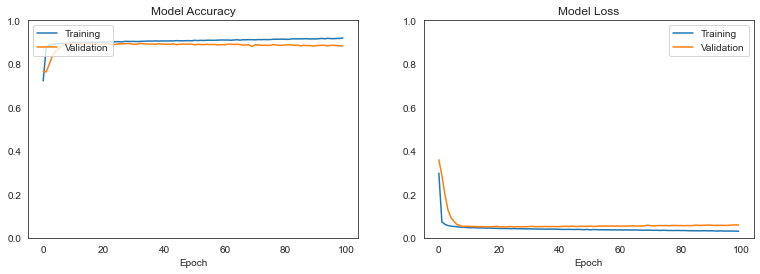

In [634]:
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns

def plots(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

    # plot accuracy
    ax1.plot(acc, label='Training')
    if val_acc is not None:
        ax1.plot(val_acc, label='Validation')

    ax1.set_xlabel('Epoch')
    ax1.set_title('Model Accuracy')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1])

    # plot loss
    ax2.plot(loss, label='Training')
    if val_loss is not None:
        ax2.plot(val_loss, label='Validation')

    ax2.set_xlabel('Epoch')
    ax2.set_title('Model Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylim([0,1])

    plt.show()

plt.rcParams["figure.figsize"] = (13,4)
plots(history.history["soft_acc"],history.history['val_soft_acc'],
      history.history["loss"],history.history['val_loss'])